<a href="https://colab.research.google.com/github/TranThiDieuHien/DO_AN_1/blob/main/Ph%C3%A2n_t%C3%ADch_d%E1%BB%AF_li%E1%BB%87u.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [264]:
#import thư viện
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 50
plt.rcParams.update({'font.size': 18})
import os
import string
from scipy.stats import norm

from wordcloud import WordCloud,STOPWORDS
stopwords = list(STOPWORDS)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score 
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer as CVTZ

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer


In [265]:
def set_seed(seed=31415):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

def RMSE(Y,YHAT):
    return np.sqrt(mean_squared_error(Y,YHAT))

HOTEL INFORMATION

In [266]:
#doc file
data = pd.read_csv("ThuaThienHue_Infor.csv")

In [267]:
data.sample(10)

,HAddress,HAttractions,HGFW,HImages,HLanguage,HName,HPMax,HPMin,HPRange,HQuestions,...,HRNumber,HRank,HRankreview,HRating,HRestaurants,HReview,HRoom,HStyles,HVideos,URL
689,"Number 8 Lane 43 Nguyen Cong Tru Street, Hue 5...",25.0,91.0,60.0,"English, Vietnamese",Canary Boutique Hotel,$22,$15,$15 - $22,Which popular attractions are close to Canary ...,...,312,#15 of 209 hotels in Hue,45.0,20.0,131.0,Excellent,15,"Modern,Quiet",4.0,https://www.tripadvisor.com/Hotel_Review-g2939...
485,"64 Alley, Nguyen Sinh Cung Street, Hue 530000 ...",1.0,76.0,2.0,NaN,Daisy Hostel,$14,$12,$12 - $14,Which popular attractions are close to Daisy H...,...,13,#74 of 267 Specialty lodging in Hue,4.0,2.0,20.0,Very good,14,Budget,1.0,https://www.tripadvisor.com/Hotel_Review-g2939...
154,NaN,0.0,0.0,NaN,NaN,Nhu Y Homestay,NaN,NaN,NaN,NaN,...,0,NaN,0.0,NaN,0.0,NaN,0,NaN,0.0,https://www.tripadvisor.com/Hotel_Review-g2939...
427,"05/14 Nguyen Cong Tru, Hue 530000 Vietnam",26.0,94.0,15.0,English,Amy Hostel Hue,$20,$11,$11 - $20,Which popular attractions are close to Amy Hos...,...,17,#39 of 267 Specialty lodging in Hue,5.0,NaN,138.0,Excellent,12,NaN,6.0,https://www.tripadvisor.com/Hotel_Review-g2939...
198,"5 Nguyen Sinh Cung, Hue Vietnam",5.0,55.0,NaN,NaN,Cock Homestay,NaN,NaN,NaN,Which popular attractions are close to Cock Ho...,...,0,NaN,0.0,NaN,23.0,NaN,0,NaN,0.0,https://www.tripadvisor.com/Hotel_Review-g2939...
396,"40 Ben Nghe, Hue Vietnam",19.0,94.0,NaN,NaN,Nhat Nam Hotel,NaN,NaN,NaN,Which popular attractions are close to Nhat Na...,...,5,#53 of 183 B&Bs / Inns in Hue,40.0,NaN,135.0,Very good,10,NaN,NaN,https://www.tripadvisor.com/Hotel_Review-g2939...
220,"46 Pham Van Dong, Hue Vietnam",26.0,94.0,NaN,Vietnamese,Hotel Thanh Tuyen,NaN,NaN,NaN,Which popular attractions are close to Hotel T...,...,0,NaN,0.0,NaN,137.0,NaN,16,NaN,0.0,https://www.tripadvisor.com/Hotel_Review-g2939...
459,NaN,0.0,NaN,NaN,NaN,Na Homestay And Coffee,$18,$15,$15 - $18,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,Hue,NaN,NaN,https://www.tripadvisor.com/Hotel_Review-g2939...
309,"8/11, Le Huu Trac, Phuong Tay Loc, Hue 530000 ...",4.0,53.0,NaN,NaN,OYO 921 Truong An Motel,$23,$11,$11 - $23,Which popular attractions are close to OYO 921...,...,NaN,NaN,NaN,NaN,23.0,NaN,16,NaN,NaN,https://www.tripadvisor.com/Hotel_Review-g2939...
252,"5/1 le Hong Phong Str Phu Nhuan Ward, Hue Vietnam",6.0,80.0,4.0,NaN,Rabbit Motel,$17,$10,$10 - $17,Which popular attractions are close to Rabbit ...,...,3,#102 of 209 hotels in Hue,50.0,30.0,28.0,Excellent,16,NaN,1.0,https://www.tripadvisor.com/Hotel_Review-g2939...


In [268]:
data.columns.values

array(['HAddress', 'HAttractions', 'HGFW', 'HImages', 'HLanguage',
       'HName', 'HPMax', 'HPMin', 'HPRange', 'HQuestions', 'HRImages',
       'HRNumber', 'HRank', 'HRankreview', 'HRating', 'HRestaurants',
       'HReview', 'HRoom', 'HStyles', 'HVideos', 'URL'], dtype=object)

In [269]:
#Tính phần trăm cho từng giá trị trong cột dữ liệu và vẽ biểu đồ trực quan barplot
def stat_table(a, size = (10,15)):
    x = data.groupby(a)[a].count()
    dt = pd.DataFrame(x)
    dt.columns = ['Percent']
    percent = []
    for i in dt['Percent']:
        x = (i/len(data[a]))*100
        percent.append(x)
    dt['Percent'] = percent
    print(dt)
    mylabels = dt.index
    fig = plt.figure(figsize = (5, 10))
    # barplot
    sns.barplot(percent, mylabels, data = dt, orient = 'h')

             Percent
HReview             
Average     6.936416
Excellent  34.393064
Poor        2.601156
Terrible    1.589595
Very good  15.173410


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


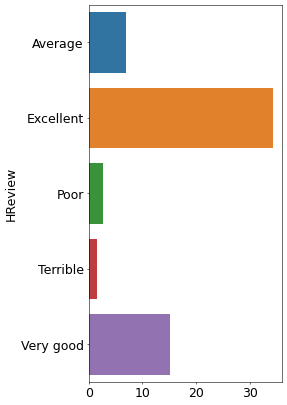

In [270]:
stat_table("HReview")

Ta thấy được rằng số lượng khách sạn được đánh giá là Excellent và Very good là rất cao, chiếm số phần trăm lớn hơn gấp nhiều lần so với Average, Poor và Terrible.

=> Chứng tỏ độ thỏa mãn của khách hàng đối với đa số khách sạn ở Huế là rất cao

=> Khách sạn ở Huế phù hợp để được chọn là nơi nghỉ ngơi khi đi du lịch, công tác tại Huế.


In [271]:
new_data = data.dropna()
print(new_data)

                                              HAddress  HAttractions  HGFW  \
26                          46 Chu Van An, Hue Vietnam          27.0  92.0   
27                   4 Tran Quang Khai St, Hue Vietnam          28.0  93.0   
28   5 Lane 27 Nguyen Sinh Cung Street, Hue 530000 ...           3.0  81.0   
31            17 Nguyen Hue Street, Hue 008454 Vietnam           4.0  77.0   
33           50A Hung Vuong Street, Hue 530000 Vietnam           6.0  94.0   
..                                                 ...           ...   ...   
685               2 Luong The Vinh Street, Hue Vietnam          17.0  96.0   
688           16/7 Nguyen Cong Tru, Hue 530000 Vietnam          25.0  92.0   
689  Number 8 Lane 43 Nguyen Cong Tru Street, Hue 5...          25.0  91.0   
690             17 Nguyen Thai Hoc, Hue 530000 Vietnam          27.0  92.0   
691         4/34 Nguyen Tri Phuong Street, Hue Vietnam          14.0  97.0   

     HImages                             HLanguage  \
26      1

In [272]:
#Sap xep lai du lieu theo thu tu
index = []
print(len(new_data))
for i in range (1, len(new_data)+1):
    index.append(i)
new_data["Index"] = index
index1 = new_data.set_index("Index")
new_data = index1.sort_index()
new_data.head(10)

79


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,HAddress,HAttractions,HGFW,HImages,HLanguage,HName,HPMax,HPMin,HPRange,HQuestions,...,HRNumber,HRank,HRankreview,HRating,HRestaurants,HReview,HRoom,HStyles,HVideos,URL
Index,,,,,,,,,,,,,,,,,,,,,
1,"46 Chu Van An, Hue Vietnam",27.0,92.0,14.0,"English, Vietnamese",Hong Thien Backpackers Hotel,$18,$15,$15 - $18,Which popular attractions are close to Hong Th...,...,338,#6 of 75 hostels in Hue,4.5,2.0,160.0,Excellent,12,Budget,8.0,https://www.tripadvisor.com/Hotel_Review-g2939...
2,"4 Tran Quang Khai St, Hue Vietnam",28.0,93.0,193.0,"English, Vietnamese",Villa Hue,"$1,074",$29,$29 - $1074,Which popular attractions are close to Villa H...,...,369,#32 of 138 hotels in Hue,4.5,4.0,185.0,Excellent,34,"Quiet,Mid-range",22.0,https://www.tripadvisor.com/Hotel_Review-g2939...
3,"5 Lane 27 Nguyen Sinh Cung Street, Hue 530000 ...",3.0,81.0,62.0,"English, Vietnamese",Charming Riverside Hotel,$15,$13,$13 - $15,Which popular attractions are close to Charmin...,...,374,#6 of 138 hotels in Hue,5.0,2.0,24.0,Excellent,21,"Quiet,Charming",8.0,https://www.tripadvisor.com/Hotel_Review-g2939...
4,"17 Nguyen Hue Street, Hue 008454 Vietnam",4.0,77.0,398.0,"English, French, Chinese, Vietnamese",Mondial Hotel Hue,$49,$29,$29 - $49,Which popular attractions are close to Mondial...,...,467,#46 of 138 hotels in Hue,4.0,4.0,20.0,Very good,106,"Mid-range,Business",27.0,https://www.tripadvisor.com/Hotel_Review-g2939...
5,"50A Hung Vuong Street, Hue 530000 Vietnam",6.0,94.0,683.0,"English, Vietnamese",Vinpearl Hotel Hue,$104,$61,$61 - $104,Which popular attractions are close to Vinpear...,...,511,#1 of 138 hotels in Hue,5.0,5.0,74.0,Excellent,213,"Modern,Business",28.0,https://www.tripadvisor.com/Hotel_Review-g2939...
6,"29 Doi Cung Str, Hue Vietnam",28.0,94.0,295.0,Vietnamese,Midtown Hotel Hue,$48,$35,$35 - $48,Which popular attractions are close to Midtown...,...,518,#43 of 138 hotels in Hue,4.0,4.0,190.0,Very good,88,"River View,Modern",4.0,https://www.tripadvisor.com/Hotel_Review-g2939...
7,"7/64 Nguyen Cong Tru Phu Hoi, Hue 530000 Vietnam",25.0,91.0,59.0,Vietnamese,New Valentine Hotel,$19,$12,$12 - $19,Which popular attractions are close to New Val...,...,543,#26 of 138 hotels in Hue,4.5,2.0,134.0,Excellent,20,"Budget,Centrally Located",4.0,https://www.tripadvisor.com/Hotel_Review-g2939...
8,"59 Vo Thi Sau, Phu Hoi Ward, Hue 530000 Vietnam",27.0,93.0,111.0,"English, French, Vietnamese",Thanh Lich Hue Hotel,$45,$24,$24 - $45,Which popular attractions are close to Thanh L...,...,573,#9 of 138 hotels in Hue,4.5,3.0,145.0,Excellent,50,"City View,Family",27.0,https://www.tripadvisor.com/Hotel_Review-g2939...
9,"49 Le Loi Street, Hue 530000 Vietnam",26.0,94.0,382.0,Vietnamese,Century Riverside Hue Hotel,$57,$33,$33 - $57,Which popular attractions are close to Century...,...,604,#49 of 138 hotels in Hue,3.5,4.0,134.0,Very good,125,"Great View,River View",61.0,https://www.tripadvisor.com/Hotel_Review-g2939...


In [273]:
location = []
atc = new_data["HAttractions"]
gfw = new_data["HGFW"]
rn = new_data["HRestaurants"]
for i in range(1, len(new_data)+1):
    loca = atc[i] + gfw[i] + rn[i]
    location.append(loca)
new_data["Location"] = location
print(new_data[["HName", "Location"]].sample(10))

                               HName  Location
Index                                         
60     Ks Nam Phuong Riverside Villa     138.0
52              Minh Thai Guesthouse     185.0
40                    Lucky Homestay     285.0
51               Binh Duong II Hotel     127.0
11             Hong Thien Ruby Hotel     279.0
75                 Thai Binh Hotel 2     207.0
16            Hue Four Seasons Hotel     250.0
65                     Nhat Le Hotel     206.0
21                     EMM Hotel Hue     133.0
55                     Duy Tan Hotel     210.0


In [274]:
#Xoa ky tu "&" trong cot
new_data["HPMax"] = new_data["HPMax"].str.replace(r'\D', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


Phát biểu giả thuyết
- $$H_{0}: \mu_{0} = \mu_{1}$$
    Giá tiền tỉ lệ thuận với số lượng địa điểm vui chơi, ăn uống
- $$H_{1}: \mu_{0} <> \mu_{1}$$
    Giá tiền không tỉ lệ thuận với số lượng địa điểm vui chơi, ăn uống

In [275]:
#Su dung thong ke t_test
for i in range(1, len(new_data)+1):
      new_data["HPMax"][i] = int(new_data["HPMax"][i])
      new_data["Location"][i] = int(new_data["Location"][i] )
stat, p_value = stats.ttest_ind(new_data["HPMax"], new_data["Location"])
print('Stat =', stat, 'P_value =', p_value)
if p_value < 0.05:
    print('''Có bằng chứng thống kê để bác bỏ giả thuyết H0. Điều này ngụ ý rằng
          giá tiền khách sạn không tỉ lệ thuận với số lượng địa điểm vui chơi, ăn uống gần khách sạn''')
else:
    print('''Chưa có bằng chứng thống kê để bác bỏ giả thuyết H0. Điều này ngụ ý rằng
          giá tiền khách sạn tỉ lệ thuận với số lượng địa điểm vui chơi, ăn uống gần khách sạn''')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Stat = -11.474055483278514 P_value = 1.7499803730252178e-22
Có bằng chứng thống kê để bác bỏ giả thuyết H0. Điều này ngụ ý rằng
          giá tiền khách sạn không tỉ lệ thuận với số lượng địa điểm vui chơi, ăn uống gần khách sạn


Nhận xét: Giá tiền khách sạn không tỉ lệ thuận với số lượng địa điểm vui chơi, ăn uống gần khách sạn.

HOTEL REVIEW COMMENTS

In [276]:
#doc file
data_comment = pd.read_csv("ThuaThienHue.csv")

In [277]:
data_comment.sample(4)

,HComment,HCommenter,HContribute,HDate,HThanks,HTime,HTravelType,HTravelerRating,h_Hotel_name,h_reviewer_address,h_reviewer_id,h_title_comment,h_url
15779,This hotel is very well situated. The staff is...,Catherine S,4.0,Oct-15,NaN,15-Dec,Trip type: Traveled as a couple,5.0,Hue Serene Palace Hotel,"Bordeaux, France",https://www.tripadvisor.com/Profile/250catherines,Nice and quiet hotel,https://www.tripadvisor.com/Hotel_Review-g2939...
7540,Dated decor and inefficient staff made this a ...,nettenz,18.0,May-08,13.0,08-Jun,Traveled as a couple,1.0,Century Riverside Hue Hotel,New Zealand,https://www.tripadvisor.com/Profile/nettenz,well past its use by date,https://www.tripadvisor.com/Hotel_Review-g2939...
8239,Amazing mini hotel.Rooms are excellent. We fou...,AJAX78,86.0,Nov-08,99.0,08-Nov,Traveled as a couple,5.0,Hue Holiday Hotel,"Frankfurt, Germany",https://www.tripadvisor.com/Profile/AJAX78,Simply great!,https://www.tripadvisor.com/Hotel_Review-g2939...
20191,We were referred to this hotel from the Peace ...,Bronte K,218.0,07-Dec,97.0,07-Dec,Traveled with family,5.0,Hue Sports 1 Hotel,"Adelaide, Australia",https://www.tripadvisor.com/Profile/BigMal2,"Great Location, great value",https://www.tripadvisor.com/Hotel_Review-g2939...


Kiểm tra các giá trị null

In [278]:
# Kiem tra cac gia tri null
data_comment.isnull().sum()

HComment               635
HCommenter             636
HContribute            650
HDate                  661
HThanks               3348
HTime                  633
HTravelType           3972
HTravelerRating        628
h_Hotel_name           620
h_reviewer_address    5266
h_reviewer_id          648
h_title_comment        635
h_url                    0
dtype: int64

Làm sạch dữ liệu

In [279]:
import re

def  clean_text(text):
    """
    Lam sach cac du lieu van ban
    * ky hieu
    * doi thanh lower case
    """
    text = text.str.lower()
    text = text.apply(lambda T: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", str(T))  )
        
    return text

In [280]:
data_comment.columns.values

array(['HComment', 'HCommenter', 'HContribute', 'HDate', 'HThanks',
       'HTime', 'HTravelType', 'HTravelerRating', 'h_Hotel_name',
       'h_reviewer_address', 'h_reviewer_id', 'h_title_comment', 'h_url'],
      dtype=object)

In [281]:
data_comment['HComment']= clean_text(data_comment['HComment'])

In [282]:
data_comment[["HComment", 'HTravelerRating']].sample(10)

,HComment,HTravelerRating
11301,we highly recommend this hotel the customer se...,5.0
176,this hotel is very classy and lovely and the g...,5.0
1811,i booked this place anticipating a much needed...,5.0
17161,out of the way in hue so what cheap friendly s...,5.0
9044,our daughter stayed at this hotel last year an...,5.0
385,well located close to the railway station on t...,5.0
17628,nan,NaN
1181,very nice 4 stars hotel in the center free wif...,5.0
19826,the tigon hostel has long since gone it doesnt...,1.0
8302,my partner and i stayed here for one night and...,5.0


Đếm số lượng từng Rating

In [283]:
data_comment.HTravelerRating.value_counts()

5.0    15218
4.0     4433
3.0     1344
2.0      525
1.0      409
Name: HTravelerRating, dtype: int64

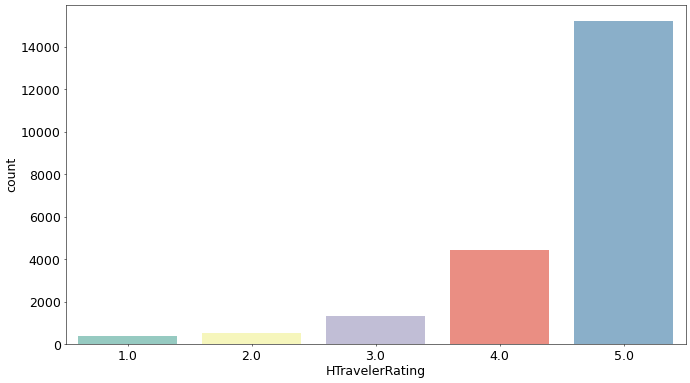

In [284]:
sns.countplot(data=data_comment,x='HTravelerRating', palette="Set3")

Nhận xét: Số lượng rating 5 sao cho các khách sạn ở Huế cao gấp nhiều lần tổng rating 1 đến 4 sao.

=> Điều này có nghĩa rằng các khách sạn ở Huế rất tốt và phù hợp với nhu cầu của khách hàng. 



Ta có thể thấy rõ rằng biến mục tiêu (Rating) không cân bằng, vì có sự khác biệt rất lớn trong rating từ 1 và 5. Vì vậy, ở đây ta sẽ sử dụng một số kỹ thuật lấy mẫu để cân bằng các lớp này.

Lấy số lượng từ trong mỗi bài đánh giá

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


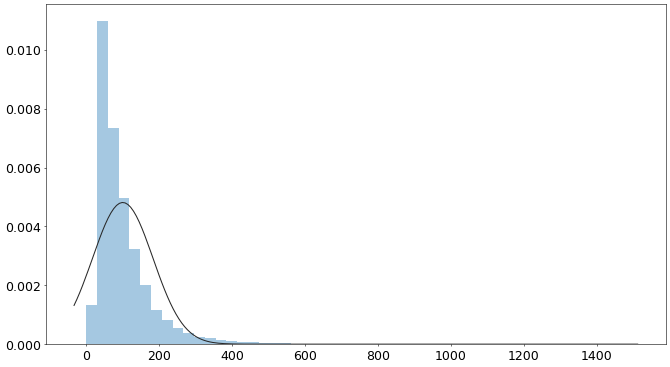

In [285]:
## Lấy số lượng từ bằng cách tách chúng theo dấu cách
words_per_review = [len(x.split(" ")) for x in data_comment['HComment']]
sns.distplot(words_per_review,fit=norm, kde=False)


Wordcloud của các từ phổ biến nhất

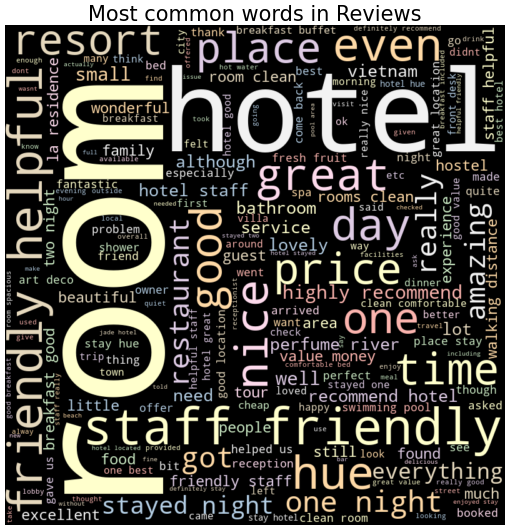

In [286]:
def wordCloud_generator(data_comment):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='black',
                          min_font_size = 10,
                          colormap='Pastel1'
                         ).generate(" ".join(data_comment.values))
    # plot the WordCloud image                        
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Most common words in Reviews",fontsize=30)
    plt.show() 
    
wordCloud_generator(data_comment['HComment'])

Xử lý trước văn bản


Bây giờ, ta sẽ xử lý trước các comment bằng cách sử dụng một số công cụ NLP như:
1. Chuyển thành lower case
2. Xoá dấu chấm câu
3. Xoá những từ dừng
4. Stemming
5. Bổ sung

In [287]:
import nltk
nltk.download('all')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Pac

In [288]:
punc=string.punctuation

stop_words = set(stopwords.words('english'))

stemmer = PorterStemmer()

lemmatizer = WordNetLemmatizer()

def data_preprocessing(txt):
    
    #converting to lowercase
    txt=txt.lower()
    
    #Removing Punctuation
    txt="".join([x for x in txt if x not in punc])
    
    #Removing stopwords
    txt=" ".join([word for word in str(txt).split() if word not in stop_words])
    
    #Stemming
    txt = " ".join([stemmer.stem(word) for word in txt.split()])
    
    #Lemmatization
    txt = " ".join([lemmatizer.lemmatize(word) for word in txt.split()])

    return txt

data_comment['text'] = data_comment['HComment'].apply(data_preprocessing)

In [289]:
data_rating = data_comment[["HComment", 'HTravelerRating', 'text']]

In [290]:
# Xoa cac hang co chua gia tri null
data_rating = data_rating[data_rating['HComment'].notna()]
data_rating = data_rating[data_rating['HTravelerRating'].notna()]
data_rating = data_rating[data_rating['text'].notna()]

In [291]:
#Xem tap du lieu moi
data_rating

,HComment,HTravelerRating,text
1,fantastic room excellent staff and fabulous ex...,5.0,fantast room excel staff fabul excurs outsid c...
2,we stayed at azerai la residence hue during th...,5.0,stay azerai la resid hue tet holiday group 3 f...
3,im just back from two nights at the azerai la ...,5.0,im back two night azerai la resid delight stay...
4,we stayed here for four nights in april 2021 o...,5.0,stay four night april 2021 obvious covid pande...
5,we spent a few days exploring hu and we were v...,5.0,spent day explor hu happi everyth hotel comfor...
...,...,...,...
22552,we were pleased with the room compared to othe...,4.0,plea room compar other price rang help staff
22553,we were met by the owner in the street he conv...,4.0,met owner street convinc u choos hotel disappo...
22554,stayed for two nights and chose the penthouse ...,4.0,stay two night chose penthous option fun binh ...
22555,guidebook recommendation we got a big airy roo...,3.0,guidebook recommend got big airi room top floo...


Vectơ hóa văn bản đầu vào

Bây giờ chúng ta sẽ vectơ rating bằng cách sử dụng điểm TF-IDF và chúng ta sẽ sử dụng toarray () để chuyển đổi ma trận thưa thớt kết quả thành ma trận dày đặc.




In [292]:
### Tạo một đối tượng của class TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer(max_features=400, min_df=0.05, max_df=0.9)
tfidf = tfidfconverter.fit_transform(data_rating['text']).toarray()

Chia thành các training sets và test sets

In [293]:
X_train, X_test, y_train, y_test = train_test_split(tfidf,data_rating['HTravelerRating'],test_size=0.2,random_state=42)

Lấy mẫu ngược bằng SMOTE

Vì biến mục tiêu của ta không cân bằng, ta sẽ sử dụng thuật toán SMOTE để lấy mẫu thêm cho các lớp thiểu số.

In [294]:
from sklearn.utils import resample
from collections import Counter


print("Trước khi lấy mẫu ngược:-")
print(Counter(y_train))


Trước khi lấy mẫu ngược:-
Counter({5.0: 12160, 4.0: 3574, 3.0: 1080, 2.0: 402, 1.0: 327})


In [295]:
# Su dung SMOTE de lay mau
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

print("Sau khi lấy mẫu ngược:-")
print(Counter(y_train))

Sau khi lấy mẫu ngược:-
Counter({5.0: 12160, 4.0: 12160, 3.0: 12160, 2.0: 12160, 1.0: 12160})


Model building

1. Naive Bayes

In [296]:
# training a Naive Bayes classifier 
#very fast
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB().fit(X_train, y_train) 

y_pred_NB=mnb.predict(X_test)

print("Accuracy of Multinominal Naive Balyes:",accuracy_score(y_test, y_pred_NB))
print(classification_report(y_pred_NB,y_test))

Accuracy of Multinominal Naive Balyes: 0.5941632466940264
              precision    recall  f1-score   support

         1.0       0.56      0.22      0.32       205
         2.0       0.37      0.16      0.23       279
         3.0       0.39      0.24      0.30       438
         4.0       0.43      0.32      0.37      1157
         5.0       0.67      0.88      0.76      2307

    accuracy                           0.59      4386
   macro avg       0.49      0.37      0.39      4386
weighted avg       0.55      0.59      0.56      4386



2.  Support Vector Machines(SVM)

REVIEW HOTEL COMMENTS VIETNAMESE

In [297]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)


In [298]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6174190606475148


In [301]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred, average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred, average='micro'))

Precision: 0.6174190606475148
Recall: 0.6174190606475148
